# IV. Введение в пространственную статистику


Пространственная статистика точек — это набор методов для анализа распределения точек в пространстве. Эти методы позволяют изучать закономерности и кластеризацию точек, а также проводить проверку гипотез о случайности распределения объектов. Сегодня мы познакомимся с пространственной статистикой точек.

Эти навыки помогут дополнить анализ исторической вспышки холеры в Лондоне (1854) – [второй проект](../projects/project2.ipynb) на нашем курсе.


0. Импортируем нужные библиотеки


In [ ]:
import geopandas as gpd   
import osmnx as ox   

import matplotlib.pyplot as plt  
import matplotlib as mpl   

from shapely.ops import voronoi_diagram  
from shapely.geometry import MultiPoint, Point  

import numpy as np  
from scipy.spatial.distance import cdist
from scipy.spatial import distance


import contextily
import seaborn
import osmnx as ox



<p style="color:#26528C; font-style:italic"><strong>pandas</strong> – фундаментальная библиотека для работы с табличными данными в Python. Предоставляет высокоуровневые структуры данных (Series, DataFrame) и богатый набор инструментов для загрузки, очистки, агрегации, группировки и преобразования данных.</p>

<p style="color:#26528C; font-style:italic"><strong>GeoPandas</strong> – надстройка над pandas, расширяющая возможности DataFrame для работы с геометрией. Хранит объекты геометрии (точки, линии, полигоны) в специальном столбце <code>geometry</code> и предоставляет методы для пространственных операций (буферизация, объединение, объединение по пространственному признаку).</p>

<p style="color:#26528C; font-style:italic"><strong>osmnx</strong> – библиотека для загрузки и анализа данных OpenStreetMap. Позволяет легко получать графы улиц, точки интереса и другие геоданные напрямую из OSM, а также выполнять маршрутизацию, визуализацию и базовый пространственный анализ городских сетей.</p>

<p style="color:#26528C; font-style:italic"><strong>Shapely</strong> – библиотека для создания и операций над геометрическими примитивами (точки, линии, полигоны). Предоставляет методы для объединения, пересечения, измерения расстояний и вычисления буферных зон, а также инструменты для генерации диаграмм Вороного (<code>voronoi_diagram</code>) и работы с множеством точек (<code>MultiPoint</code>).</p>

<p style="color:#26528C; font-style:italic"><strong>numpy</strong> – основная библиотека для работы с многомерными массивами и матрицами в Python. Обеспечивает быстродействие за счёт векторизированных операций, а также содержит базовые функции для линейной алгебры, статистики и элементарных математических преобразований.</p>

<p style="color:#26528C; font-style:italic"><strong>scipy.spatial.distance</strong> – модуль из SciPy для вычисления попарных расстояний между наборами точек. Содержит функции для различных метрик (Евклидово расстояние, Манхэттенское и др.) и умеет возвращать матрицы расстояний для последующего анализа.</p>

<p style="color:#26528C; font-style:italic"><strong>matplotlib.pyplot</strong> – модуль визуализации, вдохновлённый MATLAB. Позволяет строить 2D-графики (линии, гистограммы, scatter-плоты), настраивать оформление, добавлять подписи, легенды и работать с осями.</p>

<p style="color:#26528C; font-style:italic"><strong>matplotlib</strong> – базовый пакет для создания статических, анимированных и интерактивных визуализаций в Python. Содержит механизмы настройки стилей, колормэппингов и управления элементами фигуры (шрифты, размеры, отступы).</p>

<p style="color:#26528C; font-style:italic"><strong>contextily</strong> – утилита для подложек карт (tile basemaps) в matplotlib. Позволяет легко добавить тайловые слои (OpenStreetMap, Stamen и др.) под ваши геоплоты, автоматически приводя проекции в соответствие.</p>


## Пространственная статистика точек (Spatial Point Analysis)


Пространственная статистика точек — это набор методов для анализа распределения точек в пространстве. Эти методы позволяют изучать закономерности и кластеризацию точек, а также проводить проверку гипотез о случайности распределения объектов.


В этом разделе мы изучим данные о ДТП с Санкт-Петербурге за 2023 год

В дополнение к основной теме мы познакомимся с библиотеками seaborn и contextily. Seaborn - крутая библиотека для визуализации на основн matplotlib. Contextily помогает добавлять базовые карты (подложки).


Читаем данные о ДТП и перепроецируем в подходящую UTM-зону


In [35]:
accidents = gpd.read_file('data/spb_dtp.gpkg')

target_utm = accidents.estimate_utm_crs()
accidents_utm = accidents.to_crs(target_utm)

### 1. Расстояние до ближайшего соседа (Nearest Neighbor Distance)

Этот метод используется для измерения расстояний между точками и анализа их пространственного распределения


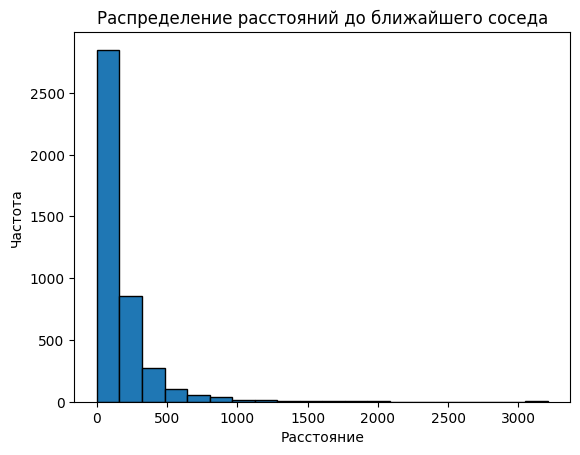

In [36]:
# Расчёт расстояний до ближайшего соседа
distances = []
for point in accidents_utm.geometry:
    dist = accidents_utm.geometry.distance(point)
    dist = dist[dist > 0]  # исключаем нулевые значения
    distances.append(np.min(dist))

# Визуализация гистроаммы распределения
plt.hist(distances, bins=20, edgecolor='black')
plt.title("Распределение расстояний до ближайшего соседа")
plt.xlabel("Расстояние")
plt.ylabel("Частота")
plt.show()


### 2. Nearest Neighbour Index

NNI (Nearest Neighbor Index, индекс ближайшего соседа) — это статистическая мера, которая позволяет оценить, насколько равномерно распределены объекты в пространстве. Давайте посмотрим, на распределение театров в Санкт-Петербурге


Как он считается?

NNI (Clark–Evans nearest-neighbor index) сравнивает **фактическое среднее расстояние до ближайшего соседа** с ожидаемым средним расстоянием при **случайном равномерном размещении** (CSR, Poisson).

- Пусть (n) — число объектов, (A) — площадь изучаемой области, $$(\lambda = n/A)$$ — плотность (кол-во объектов на единицу площади).
- **Фактическое среднее расстояние**:
  $$
  (\bar r = \frac{1}{n}\sum_i \min_{j\neq i} d(i,j))
  $$
- **Ожидаемое среднее** при CSR: $$(\mathbb{E}[r] = \frac{1}{2\sqrt{\lambda}})$$.
- **Индекс**: $$(\text{NNI} = \bar r \big/ \mathbb{E}[r])$$.

  - NNI < 1 → объекты **склонны кластеризоваться**.
  - NNI ≈ 1 → **случайное** размещение (как при CSR).
  - NNI > 1 → **регулярное/дисперсное** размещение (объекты «раздвинуты»).


In [37]:
#  Вычисление среднего расстояния до ближайшего соседа
average_nearest_neighbor_distance = np.mean(distances)

# Вычисление площади Санкт-Петербурга
spb_area = ox.geocode_to_gdf("Санкт-Петербург")
spb_area = spb_area.to_crs(spb_area.estimate_utm_crs())
spb_area = spb_area.area.values[0] 

# Расчет ожидаемого среднего расстояния для случайного распределения точек
n = len(distances)
expected_mean_distance = 0.5 * np.sqrt(spb_area / n)

# Расчет NNI
NNI = average_nearest_neighbor_distance / expected_mean_distance
NNI



0.4203735972747713

Полученное значение **NNI ≈ 0.42** существенно меньше единицы. Это говорит о том, что распределение ДТП в Петербурге **кластери­зовано**, а не случайно или равномерно.

Альтернативно можно подумать о том, как считать площадь территории без учеба административных границ, например, создавая выпуклую оболчку вокруг точек:

1. Создание выпуклой оболочки (convex hull)
   convex_hull = accidents.geometry.unary_union.convex_hull

2. Создание нового GeoDataFrame для выпуклой оболочки
   convex_hull_gdf = gpd.GeoDataFrame(
   {'geometry': [convex_hull]},
   crs=accidents.crs # Убедитесь, что координатная система одинакова
   )

Но это тоже неидеальный вариант для Санкт-Петербурга, почему?


### 3. Визуальное исследование точек


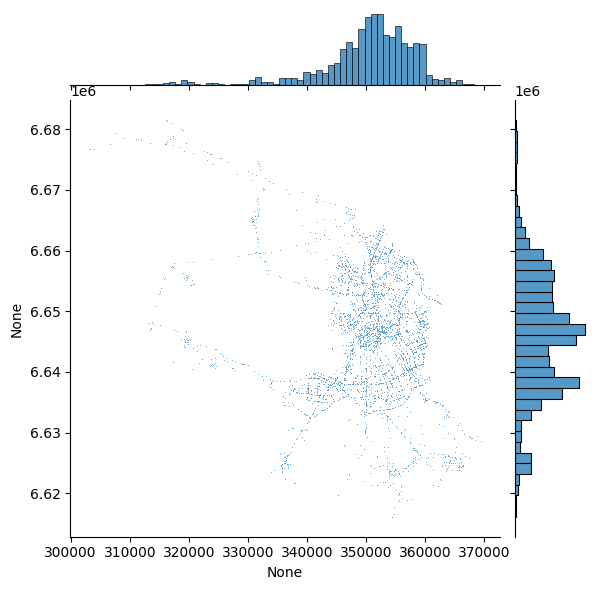

In [38]:
seaborn.jointplot(x=accidents_utm.geometry.x, y=accidents_utm.geometry.y, data=accidents_utm, s=0.5);

Это хороший старт: благодаря гистроамме мы видим, что точки склонны сосредотачиваться в центре города и на юге. Но без знания города, тяжело оценить размещение объектов. Давайте добавим на карту basemap


Сделаем это с помощью библиотеки contextily


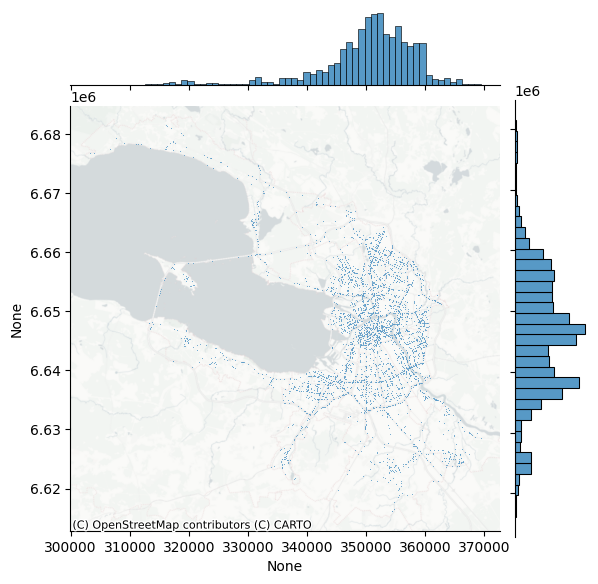

In [39]:
joint_axes = seaborn.jointplot(
    x=accidents_utm.geometry.x, y=accidents_utm.geometry.y, data=accidents_utm, s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    source=contextily.providers.CartoDB.PositronNoLabels,
    crs=target_utm,
)

### 4. Плотность на основе регулярной сетки


Отобразим плотность на основе ячеек регулярной сетки


Когда слишком много точек сосредоточено в одной области, плотное наложение точек затрудняет выявление паттернов. Например, на карте видно, что в центре города сосредоточено очень много аварий, но трудно понять, является ли это равномерным распределением или есть места с особенно высокой концентрацией. Поэтому можно наложить точки на сетку и наглядно увидеть концентрацию


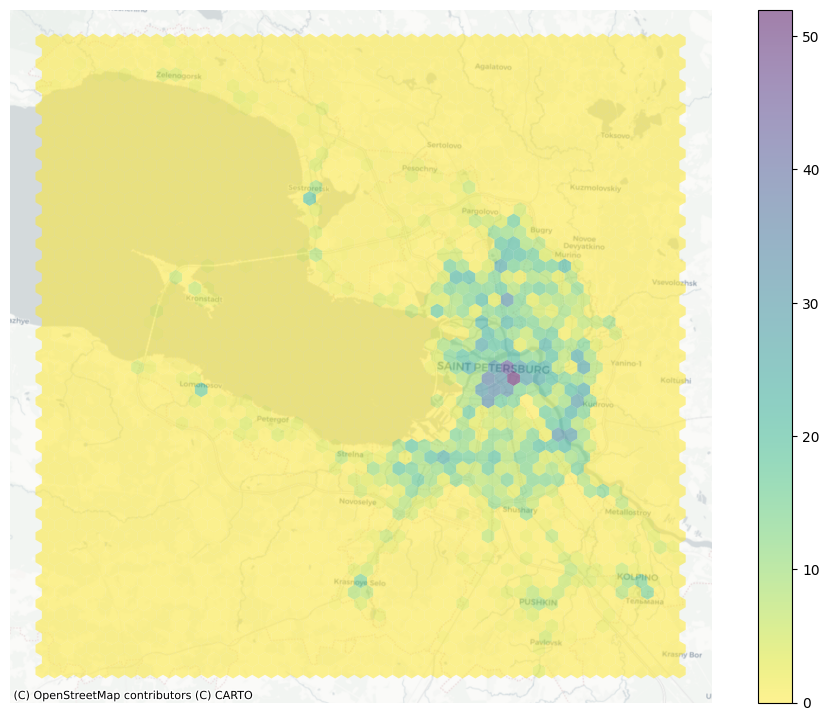

In [40]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    accidents_utm.geometry.x,
    accidents_utm.geometry.y,
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron,
    crs=target_utm,
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

### 5. Плотностная модель (Kernel Density Estimation)


Альтернативный подход оценка плотности с помощью KDE (kernel density estimation): эмпирическая аппроксимация функции плотности вероятности.

Вместо того чтобы накладывать сетку квадратов или гексагонов и подсчитывать, сколько точек попадает в каждую, KDE накладывает сетку точек на интересующее пространство и размещает функции ядра, которые учитывают точки вокруг них с разным весом в зависимости от расстояния. Эти подсчеты затем агрегируются, чтобы создать глобальную поверхность с вероятностью плотности.


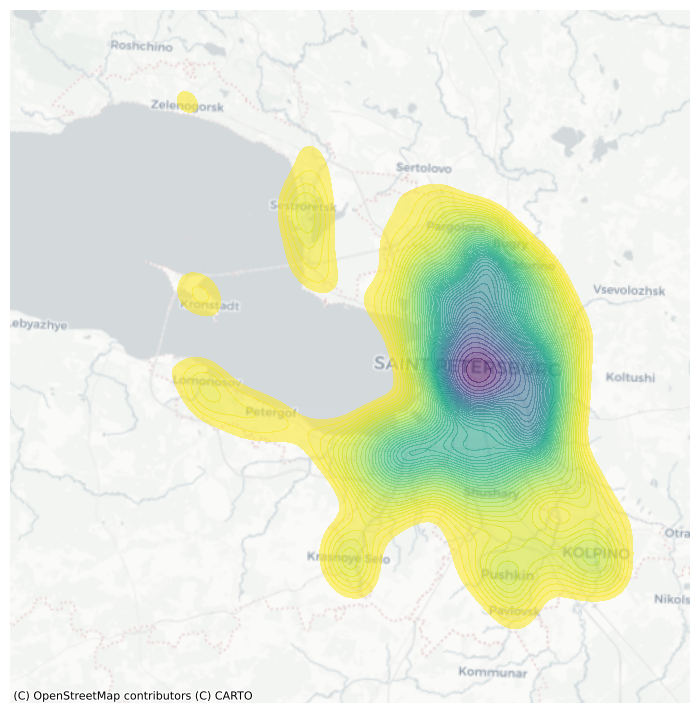

In [41]:

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap

seaborn.kdeplot(
    x=accidents_utm.geometry.x,
    y=accidents_utm.geometry.y,
    levels=50,
    fill=True,
    alpha=0.55,
    cmap="viridis_r",
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron,
    crs=target_utm,
)
# Remove axes
ax.set_axis_off()

### 6. Центрография


Это раздел пространственного анализа, посвящённый выявлению «центров» точечного распределения и оценке его структуры.
Главные задачи центрографии:

- Определить «центр тяжести» набора точек, чтобы получить представление о том, где сосредоточена максимальная масса событий (например, аварий, преступлений, точек продаж и т. д.)
- Сравнить разные распределения: сместился ли центр события со временем, отличается ли он между двумя категориями объектов.
- Оценить степень разброса: помимо центра важно знать, насколько распределены точки вокруг него.


In [42]:
from pointpats import centrography

Определим средний и медианный центр нашего набора данных


In [43]:
# Извлечение координат x и y
accidents_utm["x"] = accidents_utm.geometry.x
accidents_utm["y"] = accidents_utm.geometry.y

# Вычисление среднего центра (mean center)
mean_center = centrography.mean_center(accidents_utm[["x", "y"]])

# Вычисление медианного центра (Euclidean median)
med_center = centrography.euclidean_median(accidents_utm[["x", "y"]])

Отобразим на карте


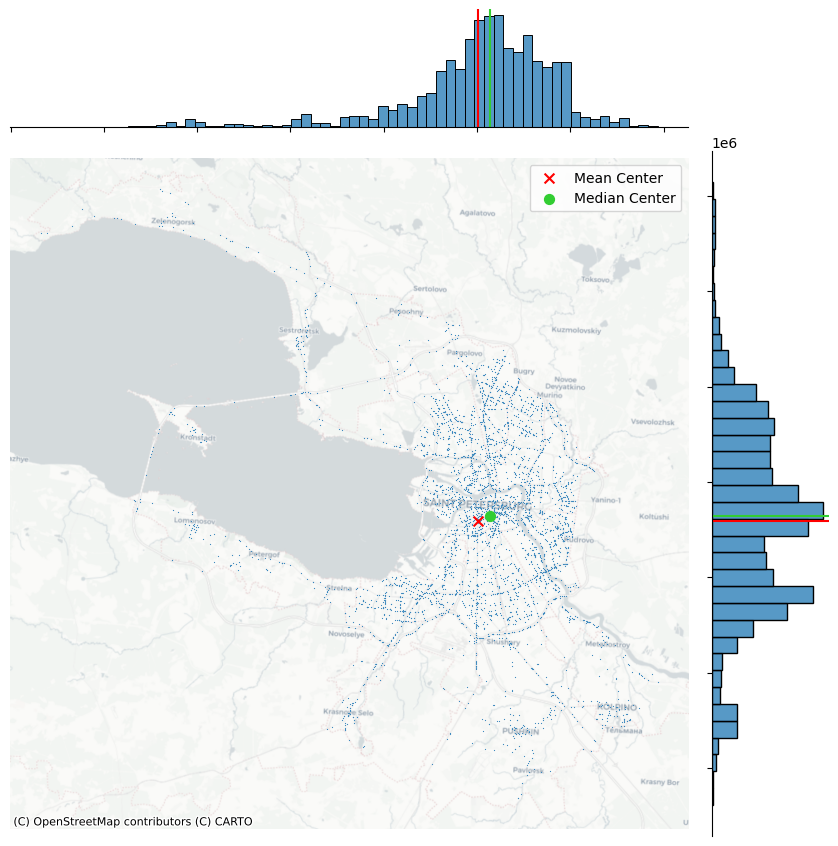

In [44]:
# Generate scatterplot
joint_axes = seaborn.jointplot(
    x="x", y="y", data=accidents_utm, s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color="red", marker="x", s=50, label="Mean Center"
)
joint_axes.ax_marg_x.axvline(mean_center[0], color="red")
joint_axes.ax_marg_y.axhline(mean_center[1], color="red")
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center,
    color="limegreen",
    marker="o",
    s=50,
    label="Median Center"
)
joint_axes.ax_marg_x.axvline(med_center[0], color="limegreen")
joint_axes.ax_marg_y.axhline(med_center[1], color="limegreen")
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(

    joint_axes.ax_joint, source=contextily.providers.CartoDB.Positron, crs= target_utm,
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

Посчитаем стандартное расстояние (пространственный аналог среднего отклонения) - мреднее расстояние точек от центра


In [45]:
centrography.std_distance(accidents_utm[["x", "y"]])

13387.089449467901

### 7. Диаграмма Вороного


Диаграмма Вороного (или разбиение Вороного) — это разбиение пространства на ячейки по следующему правилу: каждой точке-генератору (site) сопоставляется такая область, что любая точка внутри этой области ближе к нему, чем к любой другой.


Загрузим данные станций метро и разобьём территорию Петербурга на области Вороного: каждая область соответствует ближайшей станции


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'spb_admin.gpkg': 'district' (default), 'okrug'. Specify layer parameter to avoid this warning.
  result = read_func(


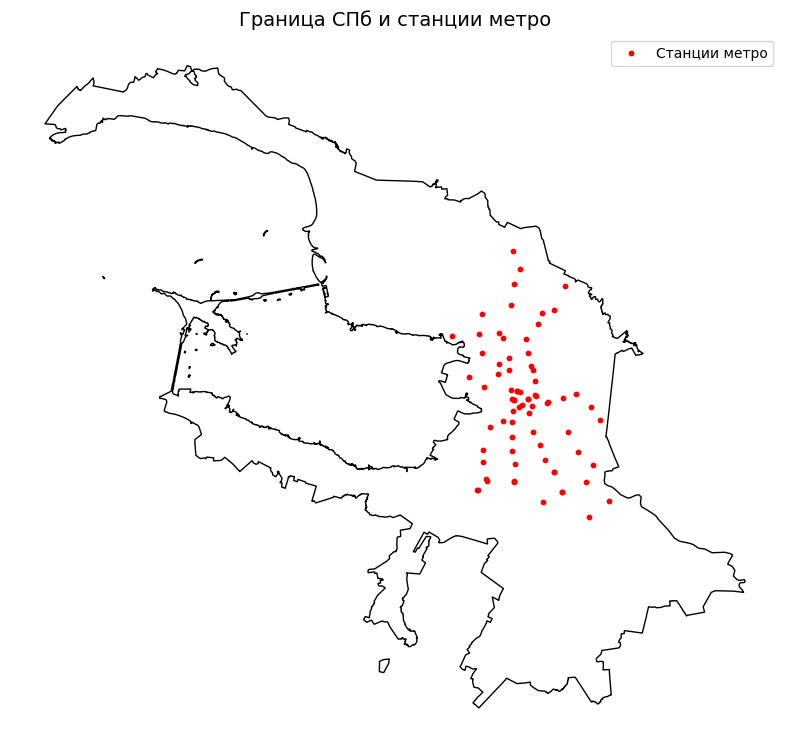

In [46]:
#Прочитаем данные о станциях метро
metro = gpd.read_file('data/spb_metro.geojson')
admin_okrug = gpd.read_file('data/spb_admin.gpkg')

#Создадим полигон с границами города на основе admin_okrug c помощью инструмента dissolve
admin_border = admin_okrug.dissolve()


# Построим карту с двумя слоями
fig, ax = plt.subplots(figsize=(8, 8))
# Сначала — граница города
admin_border.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
# Затем — станции метро
metro.plot(ax=ax, color='red', markersize=10, label='Станции метро')
# Оформление
ax.set_title('Граница СПб и станции метро', fontsize=14)
ax.axis('off')
ax.legend()

plt.tight_layout()
plt.show()


Строим диаграмму Вороного


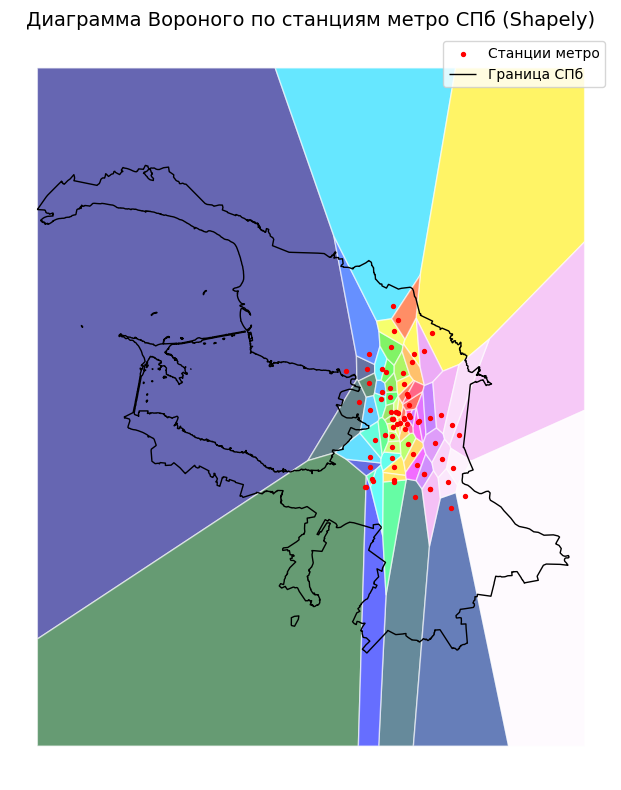

In [47]:
# 1. Собираем все точки-генераторы в один объект MultiPoint
#    Здесь каждая станция метро — это точка (Point).
#    .geometry.tolist() возвращает список shapely-геометрий.
points_mp = MultiPoint(metro.geometry.tolist())

# 2. Генерируем диаграмму Вороного по точечному набору станций метро,
#    ограничивая все ячейки рамкой города (envelope) — чтобы полигоны
#    не выходили за пределы Санкт-Петербурга.
vor = voronoi_diagram(points_mp, envelope=admin_border.geometry.iloc[0])

# 3. Создаём GeoDataFrame из полигонов Вороного:
#    конвертируем коллекцию геометрий в список и передаём его в GeoDataFrame,
#    сохраняя исходную систему координат (CRS) станций метро.
cells = list(vor.geoms)
vor_gdf = gpd.GeoDataFrame(geometry=cells, crs=metro.crs)

# 4. Визуализация результата
fig, ax = plt.subplots(figsize=(8, 8))

# 4.1. Рисуем полигоны диаграммы Вороного
#      cmap='gist_ncar' — качественная палитра с множеством цветов.
#      edgecolor='white' и alpha=0.6 делают границы полигонов чёткими,
#      но сохраняют прозрачность для наглядности.
vor_gdf.plot(
    ax=ax,
    cmap='gist_ncar',
    edgecolor='white',
    alpha=0.6
)

# 4.2. Наносим станции метро поверх полигонов
#      color='red' и markersize задают красные точки нужного размера.
metro.plot(
    ax=ax,
    color='red',
    markersize=8,
    label='Станции метро'
)

# 4.3. Рисуем контур границы города
#      boundary.plot рисует только линию границы без заливки.
admin_border.boundary.plot(
    ax=ax,
    color='black',
    linewidth=1,
    label='Граница СПб'
)

# 5. Настройка оформления
ax.set_title(
    "Диаграмма Вороного по станциям метро СПб (Shapely)",
    fontsize=14
)
ax.axis('off')   # отключаем оси, они не нужны на карте
ax.legend()      # выводим легенду по точкам и границе

plt.tight_layout()
plt.show()


Обрежем диаграмму Вороного по границам города


/var/folders/ry/9bb7wrz54vq_kn2ytlj6ynzm0000gn/T/ipykernel_5965/192412157.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  clipped_vor = gpd.clip(vor_gdf, admin_border.geometry.unary_union)


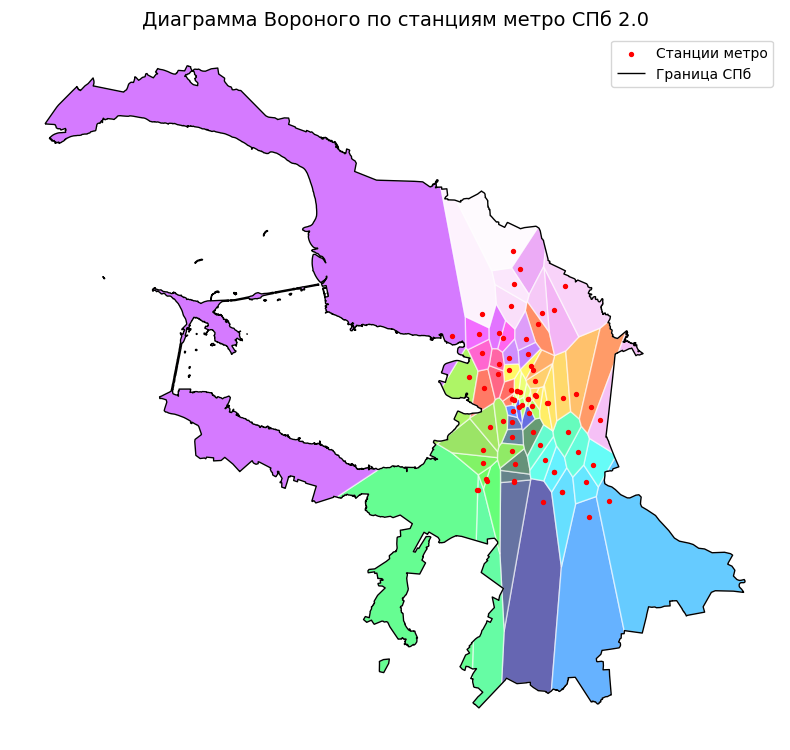

In [48]:
# 1.Выполняем обрезку (clip) полигонов Вороного по границе Санкт-Петербурга
clipped_vor = gpd.clip(vor_gdf, admin_border.geometry.unary_union)

# 2. Визуализируем результат
fig, ax = plt.subplots(figsize=(8, 8))

# 2.1. Рисуем обрезанные полигоны Вороного
clipped_vor.plot(
    ax=ax,
    cmap='gist_ncar',
    edgecolor='white',
    alpha=0.6
)

# 2.2. Наносим станции метро поверх полигонов
metro.plot(
    ax=ax,
    color='red',
    markersize=8,
    label='Станции метро'
)

# 2.3. Рисуем контур границы города
admin_border.boundary.plot(
    ax=ax,
    color='black',
    linewidth=1,
    label='Граница СПб'
)

# 3. Оформление
ax.set_title("Диаграмма Вороного по станциям метро СПб 2.0", fontsize=14)
ax.axis('off')
ax.legend()

plt.tight_layout()
plt.show()

Мы построили классическую диаграмму Вороного по станциям метро — пространство города разбилось на ячейки, каждая из которых показывает зону ближайшей станции. Это наглядно демонстрирует «зоны влияния» метро и помогает быстро оценить доступность станций для разных кварталов. Однако следует помнить, что вычисления основаны на прямом (евклидовом) расстоянии, без учёта реальной уличной сети, барьеров и особенностей рельефа. Поэтому, несмотря на полезную наглядность, для точного анализа доступности стоит использовать инструменты сетевого анализа (с некоторыми из них мы познакомимся в следующие недели)


## 4.Итог


1. Познакомились с основами анализа пространственного распределения точек на примере данных ДТП в Санкт-Петербурге.

2. Познакомились с Диаграммой Вороного и построили «зоны влияния» станций метро: каждая точка города отнесена к ближайшей станции по евклидову расстоянию.

3. Узнали об оценке кластеризации точечных объектов с помощью Nearest Neighbour Index.

При этом всегда важно помнить ограничения методов: диаграмма Вороного и NNI опираются на прямое (евклидово) расстояние и не учитывают реальную уличную сеть и препятствия. Для более точных пространственных моделей стоит применять сетевой анализ (с которым мы познакомимся на следующих занятиях).

На основе материалов этого и [прошлого](./week3_1.ipynb) занятия вы сможете полностью выполнить [второй проект](../projects/project2.ipynb)
